In [101]:
import pathlib

import astropy.table as at
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from tqdm.auto import tqdm

%matplotlib inline

In [33]:
sas_root = pathlib.Path("/mnt/ceph/users/sdssv/")
spectro_path = sas_root / "dr17/apogee/spectro"
stars_root = spectro_path / "redux/dr17/stars"
aspcap_root = spectro_path / "aspcap/dr17/synspec/"
aspcap_lco_root = spectro_path / "aspcap/dr17/synspec_rev1/"

In [34]:
allstar = at.Table.read(
    spectro_path / "aspcap/dr17/synspec_rev1/" / "allStarLite-dr17-synspec_rev1.fits"
)

In [66]:
def get_aspcap_spectrum(star):
    if star["TELESCOPE"] == "lco25m":
        star_path = aspcap_lco_root / star["TELESCOPE"] / star["FIELD"].strip()
    else:
        star_path = aspcap_root / star["TELESCOPE"] / star["FIELD"].strip()

    filename = star_path / f"aspcapStar-dr17-{star['APOGEE_ID']}.fits"
    hdulist = fits.open(filename)

    # hdr = hdulist[1].header
    flux = hdulist[1].data
    flux_err = hdulist[2].data

    return {"flux": flux, "flux_err": flux_err}

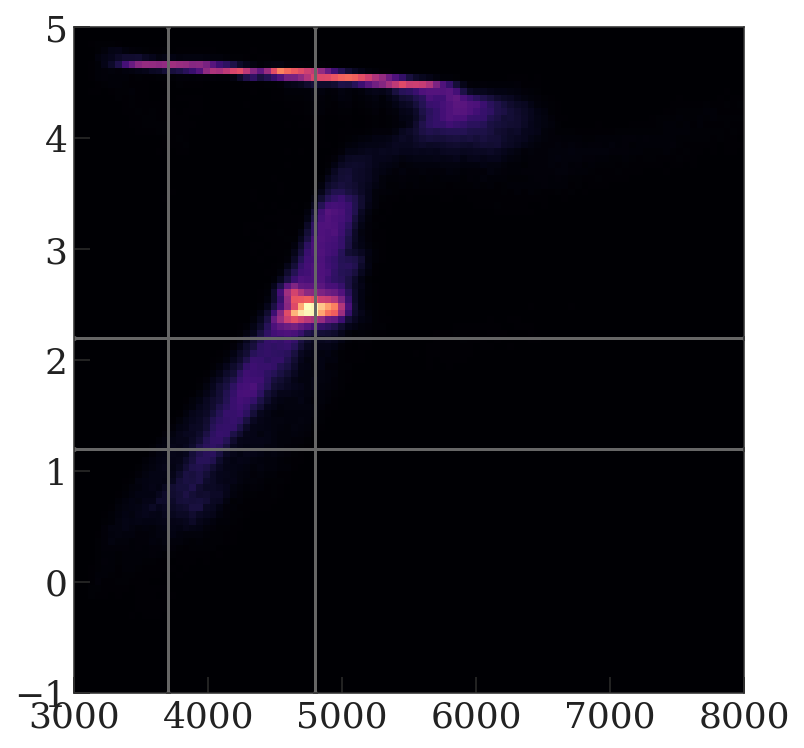

In [51]:
plt.hist2d(
    allstar["TEFF"], allstar["LOGG"], bins=(np.linspace(3000, 8000, 100), np.linspace(-1, 5, 100))
)
plt.axvline(4800)
plt.axvline(3700)
plt.axhline(2.2)
plt.axhline(1.2)

In [110]:
mask = (
    (allstar["LOGG"] > 1.2)
    & (allstar["LOGG"] < 2.2)
    & (allstar["TEFF"] < 4800)
    & (allstar["TEFF"] > 3700)
    & (allstar["SNR"] > 100)
    & (allstar["M_H"] > -3.)
    & (allstar["M_H"] < 1.)
    & (allstar["MG_FE"] > -2.)
    & (allstar["MG_FE"] < 2.)
)
stars = allstar[mask]
stars = at.unique(stars, keys="APOGEE_ID")
len(stars)

70201

In [131]:
def get_flux_err_pile(stars, progress=True):
    iter_ = tqdm if progress else lambda x: x

    flux_pile = None
    err_pile = None
    for i, star in enumerate(iter_(stars)):
        spec_data = get_aspcap_spectrum(star)
        if flux_pile is None:
            flux_pile = np.zeros((len(stars), len(spec_data["flux"])))
            err_pile = np.zeros((len(stars), len(spec_data["flux"])))
        flux_pile[i] = spec_data["flux"]
        err_pile[i] = spec_data["flux_err"]

    # Remove pixels with no flux in any spectrum
    # pix_mask = np.sum(flux_pile, axis=0) <= 0

    # Remove pixels where more than 25% of spectra have missing flux
    missing_frac = np.sum(flux_pile <= 0, axis=0) / len(flux_pile)
    pix_mask = missing_frac > 0.25
    flux_pile = np.delete(flux_pile, pix_mask, axis=1)
    err_pile = np.delete(err_pile, pix_mask, axis=1)

    # Replace missing flux with zeros and infinite errors
    missing_mask = flux_pile <= 0
    flux_pile[missing_mask] = 0.
    err_pile[missing_mask] = np.inf

    # Remove spectra where >25% of pixels are still bad
    bad_frac = np.sum(flux_pile <= 0, axis=1) / flux_pile.shape[1]
    many_bad_pix_mask = bad_frac < 0.25
    final_mask = many_bad_pix_mask

    return {"flux": flux_pile[final_mask], "flux_err": err_pile[final_mask]}, final_mask

In [136]:
data, extra_mask = get_flux_err_pile(stars)

  0%|          | 0/70201 [00:00<?, ?it/s]

In [138]:
data["flux"][np.argsort(stars["M_H"][extra_mask])].shape

(70183, 7514)

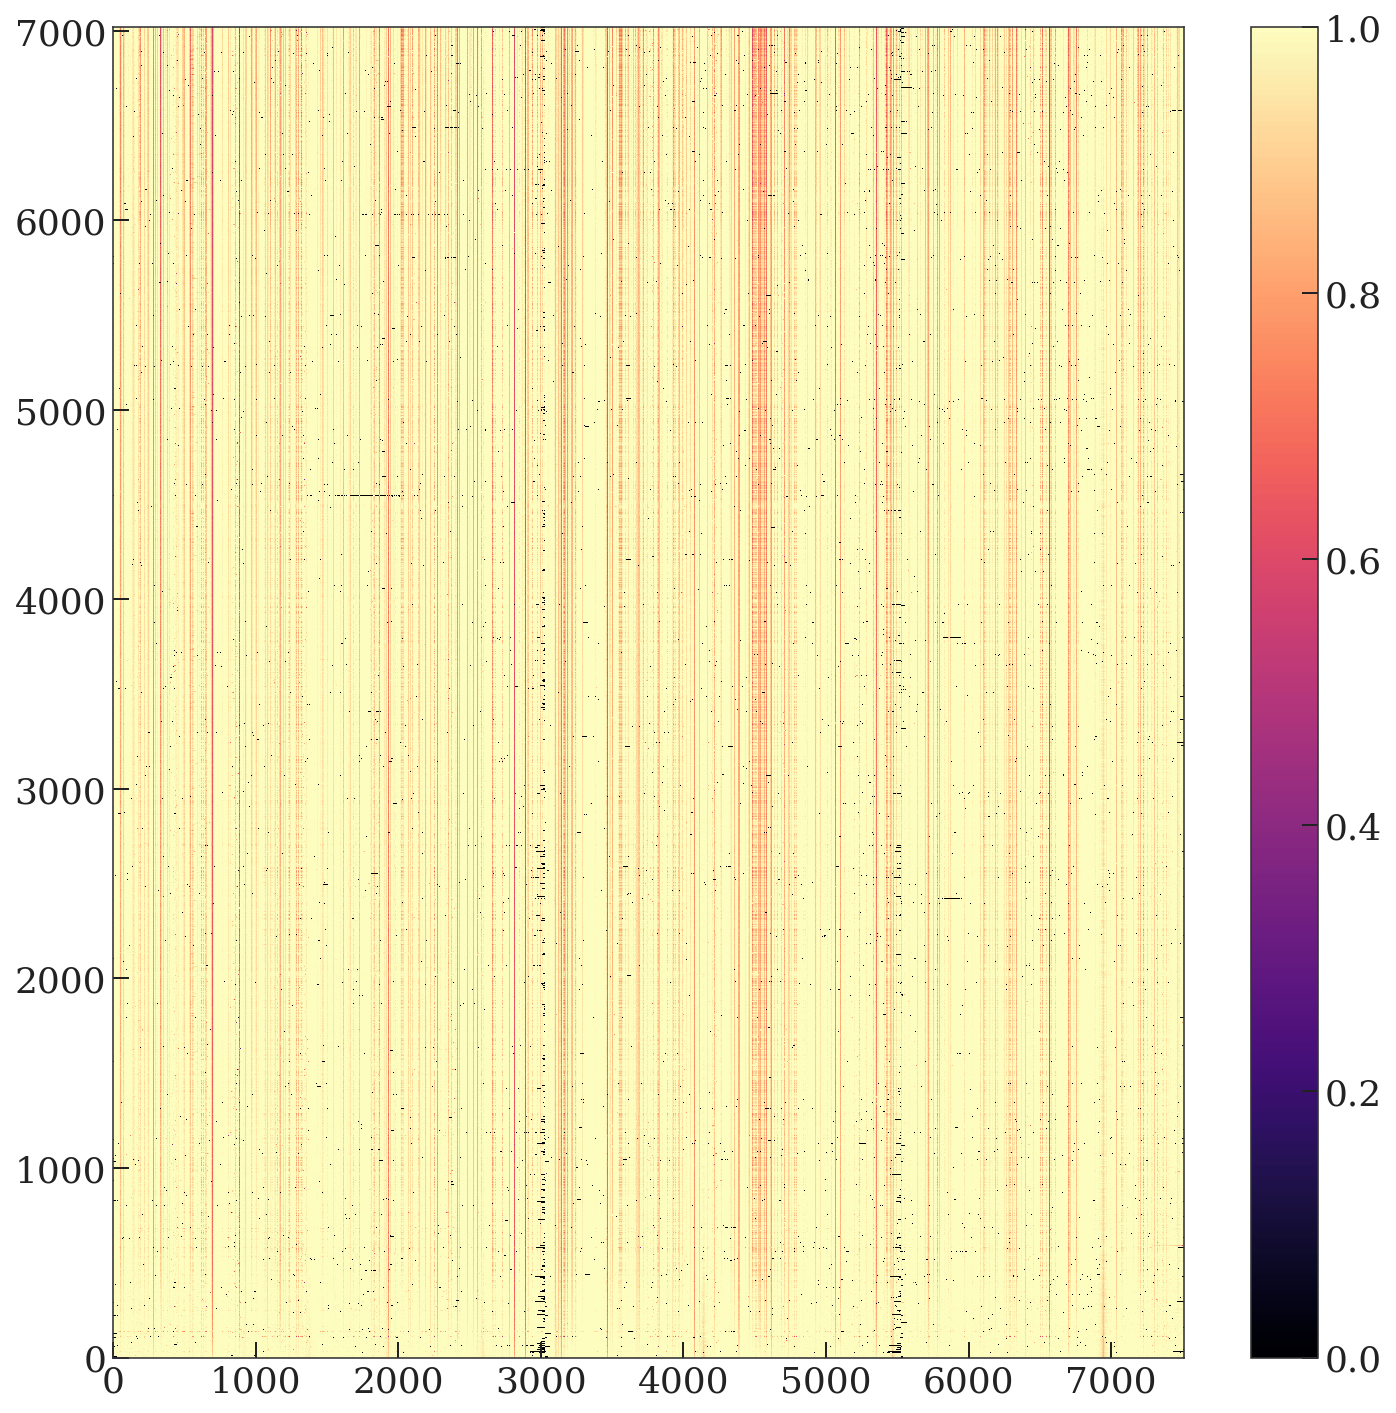

In [139]:
plt.figure(figsize=(12, 12))
plt.pcolormesh(
    data["flux"][np.argsort(stars["M_H"][extra_mask])][::10], vmin=0, vmax=1
)
plt.colorbar()

In [142]:
stars[extra_mask].write("../data/rgb-allStar.fits", overwrite=True)
at.Table(data).write("../data/rgb-allStar-spectra.fits", overwrite=True)

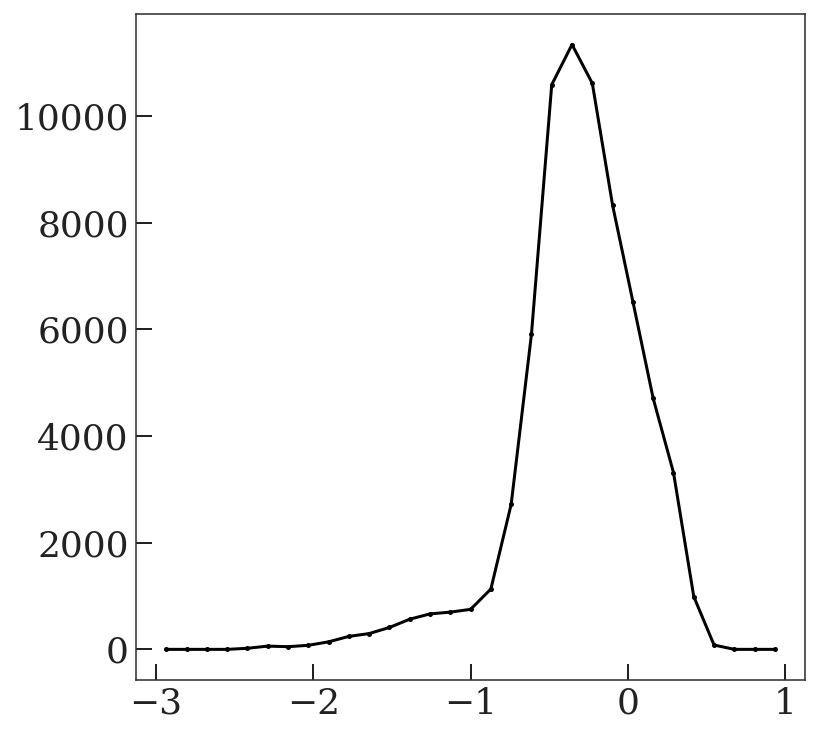

In [115]:
H, xe = np.histogram(stars["M_H"], bins=np.linspace(-3, 1., 32))
xc = 0.5 * (xe[1:] + xe[:-1])
mh_num_interp_func = interp1d(xc, H, kind="linear")
plt.plot(xc, H)

In [121]:
N_train = 2048
N_test = 1024
assert (N_train + N_test) <= len(stars)

rng = np.random.default_rng(1234)

# Re-weight so we are more uniform with M/H
prob = 1 / mh_num_interp_func(stars["M_H"].filled())
prob /= prob.sum()

idx = rng.choice(len(stars), size=N_train + N_test, replace=False, p=prob)
train_idx = idx[:N_train]
test_idx = idx[N_train:]

train_stars = stars[train_idx]
test_stars = stars[test_idx]